#### Collect previous and current relative coordinates of traffic participants  

- We plan to use the carla simulation to collect the participants' location information of past five time steps, including 5 vehicles and 5 pedestrains.


In [1]:
import carla
import random
import time
import csv

def write_relative_positions(writer, timestep, actor_type, actors, reference_location):
    for actor in actors:
        actor_location = actor.get_transform().location
        relative_x = actor_location.x - reference_location.x
        relative_y = actor_location.y - reference_location.y
        writer.writerow([timestep, actor_type, actor.id, relative_x, relative_y])

def main():
    client = carla.Client('localhost', 2000)
    client.set_timeout(10.0)
    world = client.get_world()

    blueprint_library = world.get_blueprint_library()
    ambulance = None
    vehicles = []
    pedestrians = []

    try:
        # Check available vehicles
        print([bp.id for bp in blueprint_library.filter('vehicle.*')])

        # Spawn the ambulance as the ego vehicle
        vehicle_blueprint = blueprint_library.find('vehicle.ford.ambulance')
        spawn_points = world.get_map().get_spawn_points()
        ambulance = world.spawn_actor(vehicle_blueprint, spawn_points[0])
        ambulance.set_autopilot(True)

        # Spawn other vehicles
        for _ in range(5):
            blueprint = random.choice(blueprint_library.filter('vehicle.*'))
            spawn_point = random.choice(spawn_points[1:])  # Avoid the ambulance's point
            vehicle = world.try_spawn_actor(blueprint, spawn_point)
            if vehicle:
                vehicles.append(vehicle)
                vehicle.set_autopilot(True)

        # Spawn pedestrians
        walker_controller_bp = blueprint_library.find('controller.ai.walker')
        for _ in range(5):
            blueprint = random.choice(blueprint_library.filter('walker.pedestrian.*'))
            spawn_point = random.choice(spawn_points[1:])  # Avoid the ambulance's point
            pedestrian = world.try_spawn_actor(blueprint, spawn_point)
            if pedestrian:
                controller = world.try_spawn_actor(walker_controller_bp, carla.Transform(), pedestrian)
                controller.start()
                pedestrians.append(pedestrian)

        # Prepare CSV file
        with open('relative_coordinates.csv', 'w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Timestep', 'Actor_Type', 'Actor_ID', 'Relative_X', 'Relative_Y'])

            # Run the simulation for 5 seconds
            timestep = 1  # Initialize timestep
            start_time = time.time()
            while time.time() - start_time < 5:
                world.tick()
                ambulance_location = ambulance.get_transform().location
                write_relative_positions(writer, timestep, 'Vehicle', vehicles, ambulance_location)
                write_relative_positions(writer, timestep, 'Pedestrian', pedestrians, ambulance_location)
                time.sleep(1)
                timestep += 1  # Increment timestep

    finally:
        # Clean up all actors
        print('Destroying actors')
        if ambulance:
            ambulance.destroy()
        for vehicle in vehicles:
            vehicle.destroy()
        for pedestrian in pedestrians:
            pedestrian.destroy()

if __name__ == '__main__':
    main()


['vehicle.audi.a2', 'vehicle.mercedes.sprinter', 'vehicle.chevrolet.impala', 'vehicle.citroen.c3', 'vehicle.tesla.model3', 'vehicle.dodge.charger_police_2020', 'vehicle.micro.microlino', 'vehicle.dodge.charger_police', 'vehicle.mercedes.coupe_2020', 'vehicle.harley-davidson.low_rider', 'vehicle.dodge.charger_2020', 'vehicle.ford.ambulance', 'vehicle.lincoln.mkz_2020', 'vehicle.mini.cooper_s_2021', 'vehicle.toyota.prius', 'vehicle.ford.mustang', 'vehicle.volkswagen.t2', 'vehicle.carlamotors.firetruck', 'vehicle.carlamotors.carlacola', 'vehicle.vespa.zx125', 'vehicle.nissan.patrol_2021', 'vehicle.lincoln.mkz_2017', 'vehicle.tesla.cybertruck', 'vehicle.audi.etron', 'vehicle.seat.leon', 'vehicle.diamondback.century', 'vehicle.gazelle.omafiets', 'vehicle.bmw.grandtourer', 'vehicle.bh.crossbike', 'vehicle.kawasaki.ninja', 'vehicle.yamaha.yzf', 'vehicle.audi.tt', 'vehicle.jeep.wrangler_rubicon', 'vehicle.nissan.patrol', 'vehicle.nissan.micra', 'vehicle.mini.cooper_s', 'vehicle.mercedes.coupe'

: 

- Collecting location coordinates in seperated csv files.

In [1]:
import carla
import random
import time
import csv

def write_relative_position(file, timestep, actor_type, actor_id, relative_x, relative_y):
    writer = csv.writer(file)
    writer.writerow([timestep, actor_type, actor_id, relative_x, relative_y])

def main():
    client = carla.Client('localhost', 2000)
    client.set_timeout(10.0)
    world = client.get_world()

    blueprint_library = world.get_blueprint_library()
    ambulance = None
    vehicles = []
    pedestrians = []

    files = {}

    try:
        print([bp.id for bp in blueprint_library.filter('vehicle.*')])

        vehicle_blueprint = blueprint_library.find('vehicle.ford.ambulance')
        spawn_points = world.get_map().get_spawn_points()
        ambulance = world.spawn_actor(vehicle_blueprint, spawn_points[0])
        ambulance.set_autopilot(True)

        # Open a file for the ambulance
        ambulance_file = open(f'ambulance.csv', 'w', newline='')
        files[ambulance.id] = ambulance_file
        csv.writer(ambulance_file).writerow(['Timestep', 'Actor_Type', 'Actor_ID', 'Relative_X', 'Relative_Y'])

        for _ in range(5):
            blueprint = random.choice(blueprint_library.filter('vehicle.*'))
            spawn_point = random.choice(spawn_points[1:])
            vehicle = world.try_spawn_actor(blueprint, spawn_point)
            if vehicle:
                vehicles.append(vehicle)
                vehicle.set_autopilot(True)
                # Open a file for each vehicle
                vehicle_file = open(f'vehicle_{vehicle.id}.csv', 'w', newline='')
                files[vehicle.id] = vehicle_file
                csv.writer(vehicle_file).writerow(['Timestep', 'Actor_Type', 'Actor_ID', 'Relative_X', 'Relative_Y'])

        walker_controller_bp = blueprint_library.find('controller.ai.walker')
        for _ in range(5):
            blueprint = random.choice(blueprint_library.filter('walker.pedestrian.*'))
            spawn_point = random.choice(spawn_points[1:])
            pedestrian = world.try_spawn_actor(blueprint, spawn_point)
            if pedestrian:
                controller = world.try_spawn_actor(walker_controller_bp, carla.Transform(), pedestrian)
                controller.start()
                pedestrians.append(pedestrian)
                # Open a file for each pedestrian
                pedestrian_file = open(f'pedestrian_{pedestrian.id}.csv', 'w', newline='')
                files[pedestrian.id] = pedestrian_file
                csv.writer(pedestrian_file).writerow(['Timestep', 'Actor_Type', 'Actor_ID', 'Relative_X', 'Relative_Y'])

        timestep = 1
        start_time = time.time()
        while time.time() - start_time < 20:
            world.tick()
            ambulance_location = ambulance.get_transform().location

            for vehicle in vehicles:
                vehicle_location = vehicle.get_transform().location
                relative_x = vehicle_location.x - ambulance_location.x
                relative_y = vehicle_location.y - ambulance_location.y
                write_relative_position(files[vehicle.id], timestep, 'Vehicle', vehicle.id, relative_x, relative_y)

            for pedestrian in pedestrians:
                pedestrian_location = pedestrian.get_transform().location
                relative_x = pedestrian_location.x - ambulance_location.x
                relative_y = pedestrian_location.y - ambulance_location.y
                write_relative_position(files[pedestrian.id], timestep, 'Pedestrian', pedestrian.id, relative_x, relative_y)

            time.sleep(1)
            timestep += 1

    finally:
        print('Destroying actors')
        for actor_id, file in files.items():
            file.close()
        if ambulance:
            ambulance.destroy()
        for vehicle in vehicles:
            vehicle.destroy()
        for pedestrian in pedestrians:
            pedestrian.destroy()

if __name__ == '__main__':
    main()


['vehicle.audi.a2', 'vehicle.mercedes.sprinter', 'vehicle.chevrolet.impala', 'vehicle.citroen.c3', 'vehicle.tesla.model3', 'vehicle.dodge.charger_police_2020', 'vehicle.micro.microlino', 'vehicle.dodge.charger_police', 'vehicle.mercedes.coupe_2020', 'vehicle.harley-davidson.low_rider', 'vehicle.dodge.charger_2020', 'vehicle.ford.ambulance', 'vehicle.lincoln.mkz_2020', 'vehicle.mini.cooper_s_2021', 'vehicle.toyota.prius', 'vehicle.ford.mustang', 'vehicle.volkswagen.t2', 'vehicle.carlamotors.firetruck', 'vehicle.carlamotors.carlacola', 'vehicle.vespa.zx125', 'vehicle.nissan.patrol_2021', 'vehicle.lincoln.mkz_2017', 'vehicle.tesla.cybertruck', 'vehicle.audi.etron', 'vehicle.seat.leon', 'vehicle.diamondback.century', 'vehicle.gazelle.omafiets', 'vehicle.bmw.grandtourer', 'vehicle.bh.crossbike', 'vehicle.kawasaki.ninja', 'vehicle.yamaha.yzf', 'vehicle.audi.tt', 'vehicle.jeep.wrangler_rubicon', 'vehicle.nissan.patrol', 'vehicle.nissan.micra', 'vehicle.mini.cooper_s', 'vehicle.mercedes.coupe'

: 

#### Plotting the previous and current trajectories

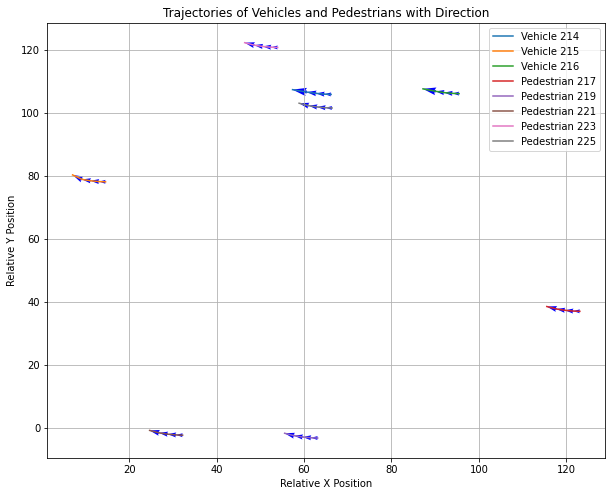

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Load data from CSV
data = pd.read_csv('relative_coordinates.csv')

# Filter data by actor type
vehicles = data[data['Actor_Type'] == 'Vehicle']
pedestrians = data[data['Actor_Type'] == 'Pedestrian']

# Create a figure
plt.figure(figsize=(10, 8))

# Function to plot trajectories with direction
def plot_with_direction(df, actor_id, marker, label_prefix):
    actor_data = df[df['Actor_ID'] == actor_id]
    # Plot the trajectory
    plt.plot(actor_data['Relative_X'], actor_data['Relative_Y'], marker=marker, label=f'{label_prefix} {actor_id}')
    # Calculate the differences to plot arrows
    x_diff = actor_data['Relative_X'].diff().fillna(0)
    y_diff = actor_data['Relative_Y'].diff().fillna(0)
    # Plot arrows
    plt.quiver(actor_data['Relative_X'][:-1], actor_data['Relative_Y'][:-1], x_diff[1:], y_diff[1:], angles='xy', scale_units='xy', scale=1, color='blue', width=0.005)

# Plot each vehicle with direction arrows
for vehicle_id in vehicles['Actor_ID'].unique():
    plot_with_direction(vehicles, vehicle_id, '', 'Vehicle')

# Plot each pedestrian with direction arrows
for pedestrian_id in pedestrians['Actor_ID'].unique():
    plot_with_direction(pedestrians, pedestrian_id, '', 'Pedestrian')

# Set plot properties
plt.title('Trajectories of Vehicles and Pedestrians with Direction')
plt.xlabel('Relative X Position')
plt.ylabel('Relative Y Position')
plt.legend()
plt.grid(True)
plt.show()
